In [1]:
import os

In [2]:
mypath = "/home/sabrine/notebook/BIWI_dataset/Training"

In [3]:
for x in os.listdir(mypath):
    print("-------------------------------")
    print(x)
    for i, f in enumerate(os.listdir(mypath + "/" + x)):
        if str(f).endswith('jpg'):
            thePath = mypath + "/" + x + "/" + f
            print(thePath)
    print("\n")

-------------------------------
036
/home/sabrine/notebook/BIWI_dataset/Training/036/036_000130-a_16388083_rgb.jpg
/home/sabrine/notebook/BIWI_dataset/Training/036/036_000269-a_16400999_rgb.jpg
/home/sabrine/notebook/BIWI_dataset/Training/036/036_000264-a_16400499_rgb.jpg
/home/sabrine/notebook/BIWI_dataset/Training/036/036_000230-a_16397663_rgb.jpg
/home/sabrine/notebook/BIWI_dataset/Training/036/036_000250-a_16399331_rgb.jpg
/home/sabrine/notebook/BIWI_dataset/Training/036/036_000090-a_16384083_rgb.jpg
/home/sabrine/notebook/BIWI_dataset/Training/036/036_000139-a_16389083_rgb.jpg
/home/sabrine/notebook/BIWI_dataset/Training/036/036_000282-a_16402331_rgb.jpg
/home/sabrine/notebook/BIWI_dataset/Training/036/036_000116-a_16386747_rgb.jpg
/home/sabrine/notebook/BIWI_dataset/Training/036/036_000003-a_16375084_rgb.jpg
/home/sabrine/notebook/BIWI_dataset/Training/036/036_000140-a_16389163_rgb.jpg
/home/sabrine/notebook/BIWI_dataset/Training/036/036_000051-a_16380085_rgb.jpg
/home/sabrine/no

Let's take the first one: /home/sabrine/notebook/BIWI_dataset/Training/036/036_000130-a_16388083_rgb.jpg

In [13]:
imageRGBpath= "/home/sabrine/notebook/BIWI_dataset/Training/036/036_000130-a_16388083_rgb.jpg"

### Face detection using Facenet

In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import sys

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
from datetime import datetime

import tensorflow as tf

if not os.path.exists('facenet'):
  !git clone https://github.com/davidsandberg/facenet --depth=1

sys.path.insert(0, './facenet/src')
import align.detect_face
import facenet
import scipy.spatial.distance as distance

In [10]:
# download pre-trained model at https://drive.google.com/open?id=0B5MzpY9kBtDVTGZjcWkzT3pldDA
model_dir = '/home/sabrine/notebook/reid/20170216-091149/'

In [11]:
# starting a session
tf.reset_default_graph()

tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_config.allow_soft_placement = True

sess = tf.Session(config=tf_config)

print('loading the detection/alignment network...')
pnet, rnet, onet = align.detect_face.create_mtcnn(sess, None)
print('done!')

print('loading the embedding network...')
meta_file, ckpt_file = facenet.get_model_filenames(model_dir)
restorer = tf.train.import_meta_graph(os.path.join(model_dir, meta_file))
restorer.restore(sess, os.path.join(model_dir, ckpt_file))
print('done!')

# getting input / output tensors
g = tf.get_default_graph()
images_in = g.get_tensor_by_name('input:0')
phase_train_in = g.get_tensor_by_name('phase_train:0')
embeddings = g.get_tensor_by_name('embeddings:0')


loading the detection/alignment network...
done!
loading the embedding network...
done!


detecting faces...


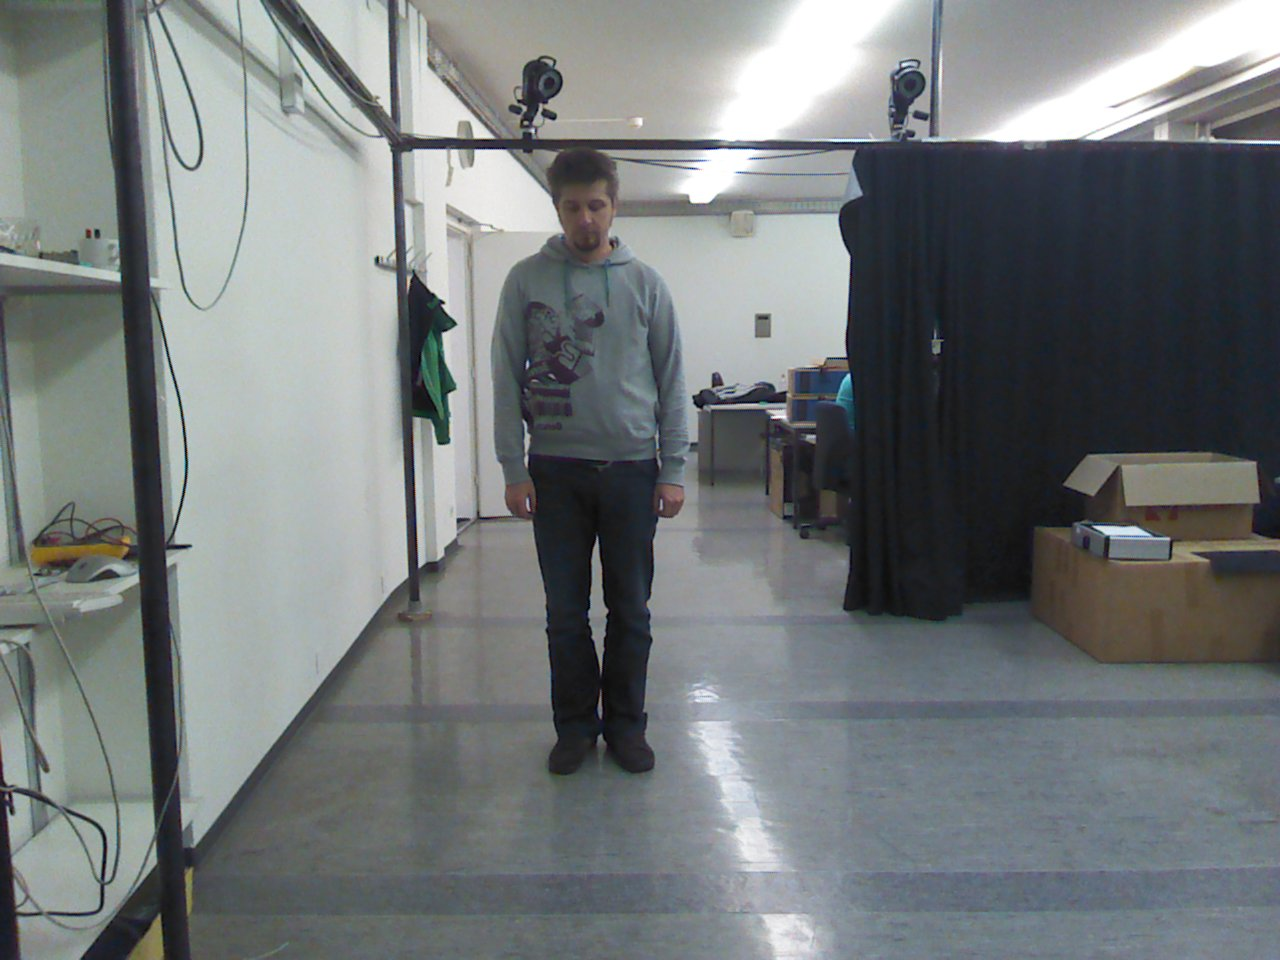

(10, 1)
done!


In [14]:
from IPython.display import Image, display

# detection parameters
minsize = 20 
threshold = [ 0.6, 0.7, 0.7 ]
factor = 0.709
             
boxes = []
keypoints = []
images = []
print('detecting faces...')

display(Image(imageRGBpath))
img = scipy.misc.imread(imageRGBpath)
bbs, kps = align.detect_face.detect_face(img, minsize, 
                                        pnet, rnet, onet, threshold, factor)
kps = np.asarray(kps)
print(kps.shape)
kps = kps.reshape([2,5,-1]).T
if len(kps) != 0:  
    images.append(img)  
    boxes.append(bbs)
    keypoints.append(kps)
    
print('done!')  

crop image to face only
done


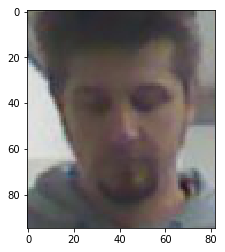

In [15]:
print('crop image to face only')
size = 160
margin = 32

faces = []

for img, bbs in zip(images, boxes):
    img_faces = []
    for x0,y0,x1,y1,_ in bbs.astype(np.int32):
        x0 = np.maximum(x0 - margin//2, 0)
        y0 = np.maximum(y0 - margin//2, 0)
        x1 = np.minimum(x1 + margin//2, img.shape[1])
        y1 = np.minimum(y1 + margin//2, img.shape[0])
        img_faces.append(scipy.misc.imresize(img[y0:y1,x0:x1], (size, size)))
        plt.imshow(img[y0:y1,x0:x1])

print("done")

In [16]:
print(y0, x0)
print(y1, x1)

(167, 543)
(262, 625)


### Different size

In [26]:
images[0].shape

(960, 1280, 3)

The corresponding depth image has the path : /home/sabrine/notebook/BIWI_dataset/Training/036/000a_000000-b_111627036_depth.pgm

In [3]:
imageDpath = "/home/sabrine/notebook/BIWI_dataset/Training/036/036_000130-b_16388045_depth.pgm"

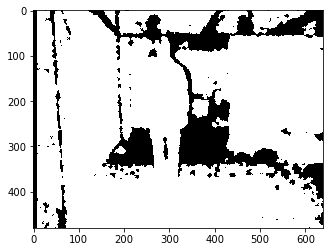

In [34]:
plt.imshow(plt.imread(imageDpath))

In [4]:
import re
import numpy

def read_pgm(filename, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.

    Format specification: http://netpbm.sourceforge.net/doc/pgm.html

    """
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return numpy.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

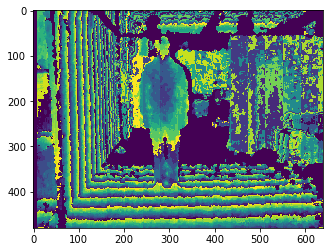

In [7]:
image = read_pgm(imageDpath, byteorder='<')
plt.imshow(image)
plt.show()

In [64]:
image

array([[    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       ..., 
       [    0,     0,     0, ..., 61704,     0,     0],
       [    0,     0,     0, ..., 57864, 57864,     0],
       [    0,     0,     0, ..., 57864, 54024,     0]], dtype=uint16)

In [49]:
plt.cm.gray


RGB images and depth images do not have the same size

### Finding the corresponding pixel in Depth image

Hypothesis: depth image and RGB image are centered in the same point and they captured the same scene

So just need to use an appropriate scale to transform RGB coordinates to depth coordinates

In [20]:
def rgbToD(y, x):
    return(y*480/960, x*640/1280)

In [21]:
y0d, x0d = rgbToD(y0, x0)

In [22]:
y1d, x1d = rgbToD(y1, x1)

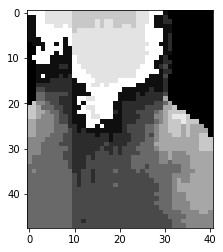

In [47]:
plt.imshow(image[y0d:y1d,x0d:x1d], plt.cm.gray)

### Not really good, will try with the floo fill algorithm

In [48]:
import cv2

In [ ]:
h, w = im_th.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)

In [50]:
cv2.floodFill(image, mask, ((y1d-y0d)/2,(x1d-x0d)/2), 255)

NameError: name 'mask' is not defined

In [79]:
image[y0d:y1d,x0d:x1d].mean()

27320.824695121952

In [76]:
np.zeros(image.shape)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [23]:
fool_fill = np.zeros(image.shape)

def floodfill(matrix, x, y):
    #"hidden" stop clause - not reinvoking for "c" or "b", only for "a".
    if matrix[x][y] > 27320:  
        fool_fill[x][y] = matrix[x][y]
        #recursively invoke flood fill on all surrounding cells:
        if x > 0:
            floodfill(matrix,x-1,y)
        if x < len(matrix[y]) - 1:
            floodfill(matrix,x+1,y)
        if y > 0:
            floodfill(matrix,x,y-1)
        if y < len(matrix) - 1:
            floodfill(matrix,x,y+1)

In [ ]:
sys.setrecursionlimit(image.shape[0] * image.shape[1])
floodfill(image, (y1d-y0d)/2, (x1d-x0d)/2)